**Important Libraries**

In [1]:
# Importing Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

**Decision Tree Model Definition**

In [4]:
# Self made Decision Tree model from scratch
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.feature_importances_ = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)
        self.feature_importances_ = self._compute_feature_importances(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        if (depth >= self.max_depth or n_samples < self.min_samples_split):
            leaf_value = self._mean_value(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for thr in thresholds:
                gain = self._variance_reduction(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        return split_idx, split_threshold

    def _variance_reduction(self, y, X_column, threshold):
        parent_variance = np.var(y)
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        v_l, v_r = np.var(y[left_idxs]), np.var(y[right_idxs])
        child_variance = (n_l/n) * v_l + (n_r/n) * v_r
        return parent_variance - child_variance

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _mean_value(self, y):
        return np.mean(y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _compute_feature_importances(self, X, y):
        importances = np.zeros(X.shape[1])

        def recurse(node, X_node, y_node):
            if node.is_leaf_node():
                return np.var(y_node) * len(y_node)
            left_idx = np.argwhere(X_node[:, node.feature] <= node.threshold).flatten()
            right_idx = np.argwhere(X_node[:, node.feature] > node.threshold).flatten()
            if len(left_idx) == 0 or len(right_idx) == 0:
                return 0
            parent_var = np.var(y_node) * len(y_node)
            left_var = np.var(y_node[left_idx]) * len(left_idx)
            right_var = np.var(y_node[right_idx]) * len(right_idx)
            gain = parent_var - (left_var + right_var)
            importances[node.feature] += gain
            recurse(node.left, X_node[left_idx], y_node[left_idx])
            recurse(node.right, X_node[right_idx], y_node[right_idx])

        recurse(self.root, X, y)
        if np.sum(importances) > 0:
            importances /= np.sum(importances)
        return importances

**Data Preprocessing, Model Calling, and Plotting Results**

/tmp/ipython-input-3252218114.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


   CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
0     2.6       1360.0      11.9         1046.0    166.0        1056.0   
1     2.0       1292.0       9.4          955.0    103.0        1174.0   
2     2.2       1402.0       9.0          939.0    131.0        1140.0   
3     2.2       1376.0       9.2          948.0    172.0        1092.0   
4     1.6       1272.0       6.5          836.0    131.0        1205.0   

   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH            Datetime  
0    113.0        1692.0       1268.0  13.6  48.9  0.7578 2004-03-10 18:00:00  
1     92.0        1559.0        972.0  13.3  47.7  0.7255 2004-03-10 19:00:00  
2    114.0        1555.0       1074.0  11.9  54.0  0.7502 2004-03-10 20:00:00  
3    122.0        1584.0       1203.0  11.0  60.0  0.7867 2004-03-10 21:00:00  
4    116.0        1490.0       1110.0  11.2  59.6  0.7888 2004-03-10 22:00:00  
<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data c

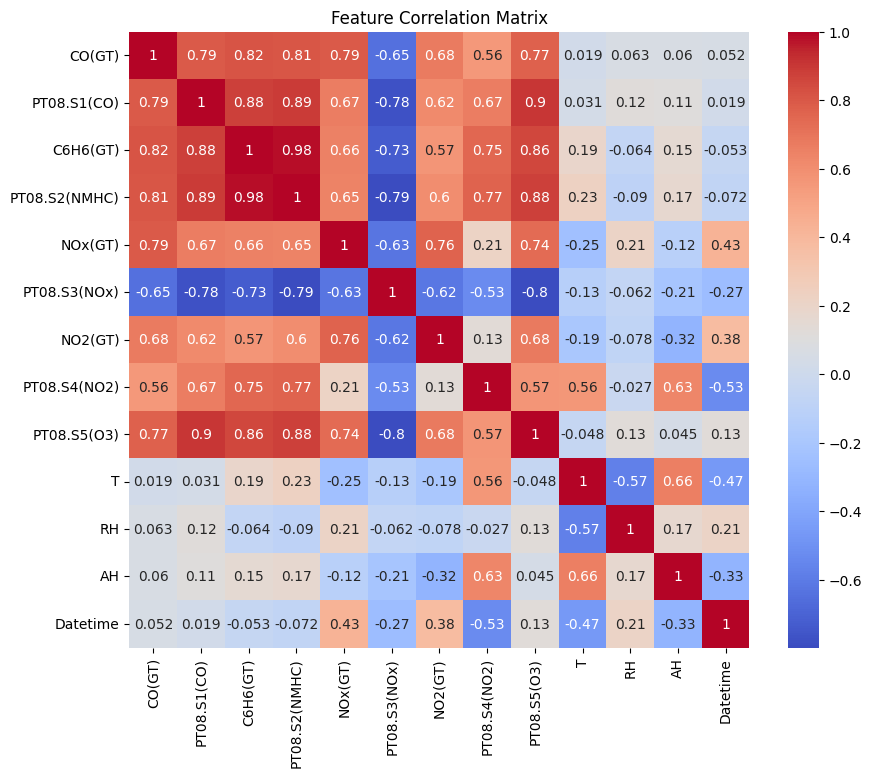

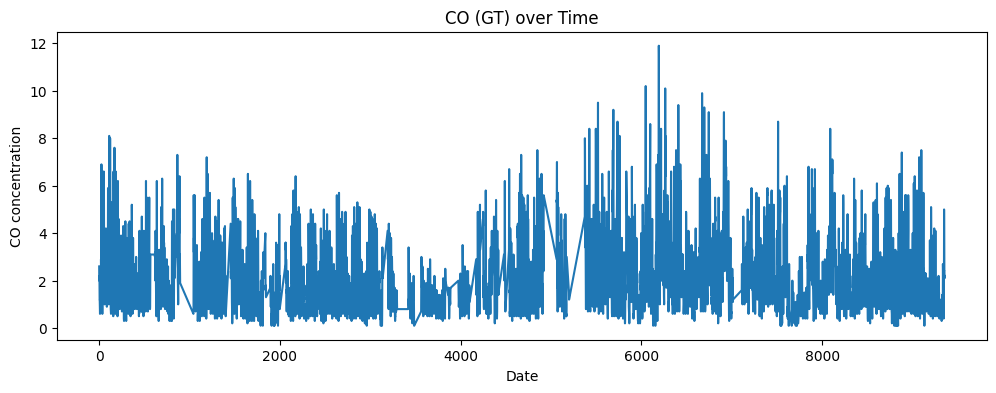

Training features shape: (7485, 9)
Testing features shape: (1872, 9)
Training target shape: (7485,)
Testing target shape: (1872,)

Training model with max_depth = 3

Training model with max_depth = 5

Training model with max_depth = 10

Training model with max_depth = None


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Performance comparison for different depths:


,Depth,Train_MSE,Train_RMSE,Train_R2,Test_MSE,Test_RMSE,Test_R2
0,3,0.677677,0.823211,0.664057,0.695229,0.833804,0.680969
1,5,0.566883,0.752916,0.718981,0.603472,0.776835,0.723075
2,10,0.256291,0.506252,0.872949,0.666871,0.816622,0.693982
3,None,0.000000,0.000000,1.000000,0.873262,0.934485,0.599272


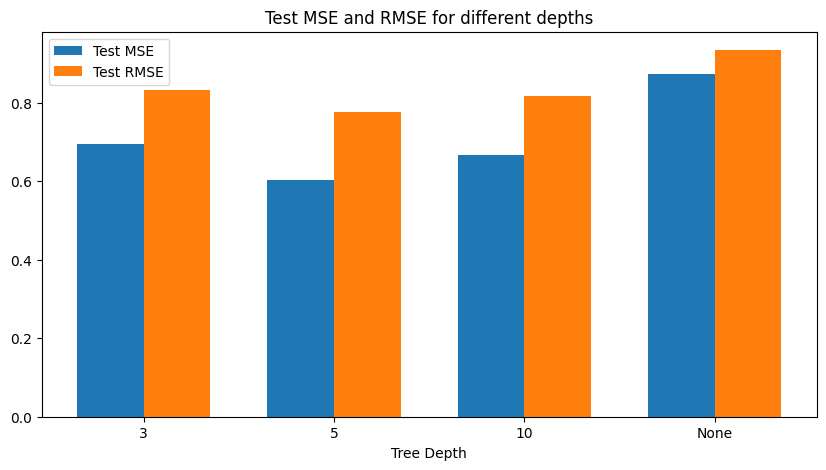

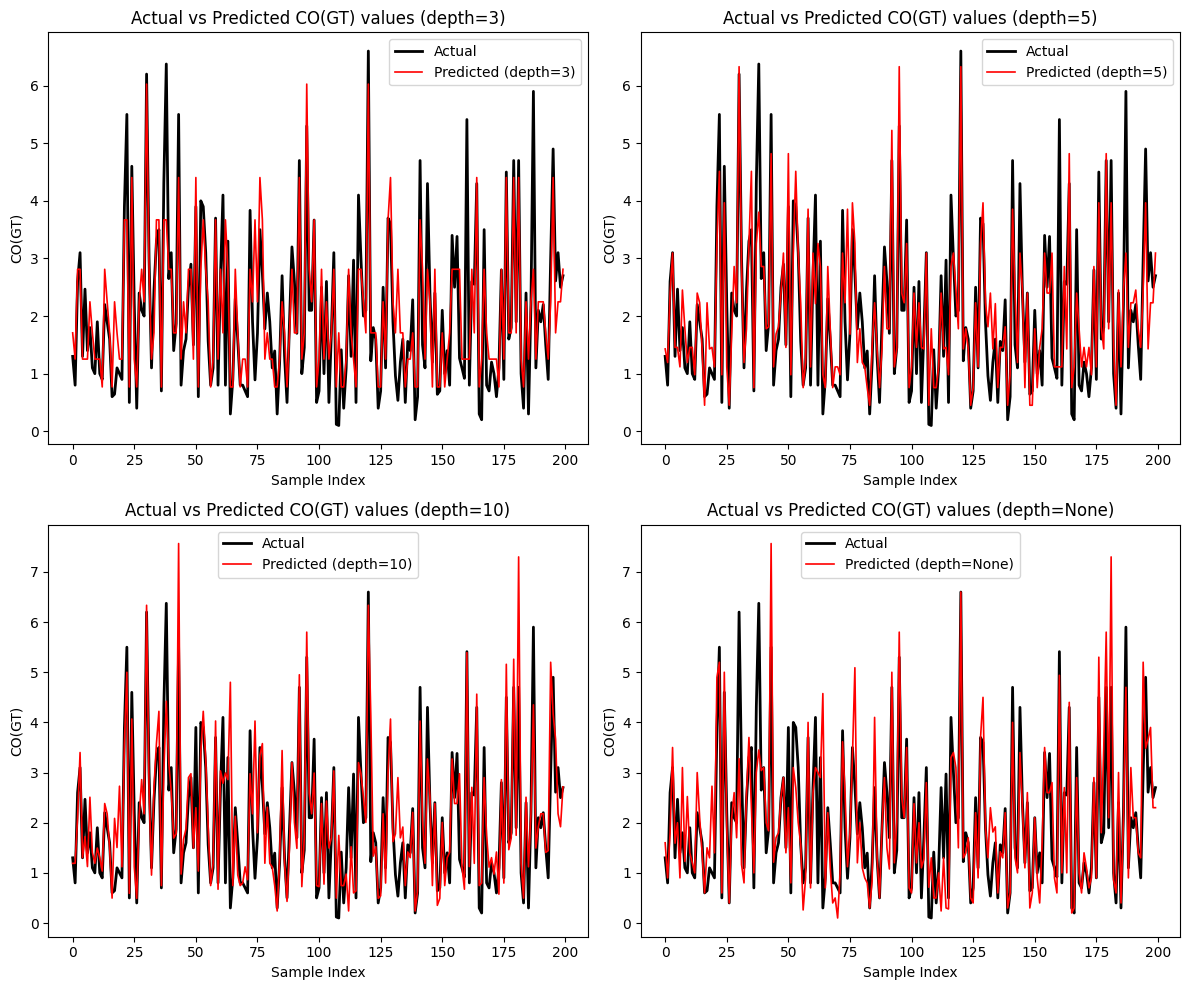


Sample comparison of Actual vs Predicted (Test data):


,Actual,Pred_depth3,Pred_depth5,Pred_depth10,Pred_depthNone
0,1.300000,1.708208,1.429522,1.189185,1.600000
1,0.800000,1.252543,1.193114,1.191419,0.900000
2,2.600000,2.812093,2.398903,2.111710,1.800000
3,3.100000,2.812093,3.093530,3.400000,3.500000
4,1.300000,1.252543,1.456106,1.303341,1.591753
5,2.467241,1.252543,1.456106,1.720533,2.000000
6,1.400000,1.252543,1.117846,1.125850,0.900000
7,1.800000,2.247324,2.451607,2.508873,3.100000
8,1.100000,1.708208,1.779234,1.408340,1.228866
9,1.000000,1.252543,1.193114,1.191419,2.521875


In [5]:
# Load the CSV file
df = pd.read_csv("AirQualityUCI.csv", sep = ';', decimal = ',', encoding = 'utf-8', low_memory = False)

# Delete unwanted (unnecessary) columns
df = df.drop(['Unnamed: 15', ',,,,,'], axis=1)

# Removing false sensor readings
df = df.replace(-200, np.nan)

# After checking for missing data, almost 90% of this column was empty so removing
df = df.drop(['NMHC(GT)'], axis = 1)

# Filling the remaining empty data cells with interpolation since the data is recorded over time
df = df.interpolate()

# Removing rows that still have no entries such as date and time as those are meaningless
df = df.dropna(subset = ['Date', 'Time'])

# Merging date and time column into one column for bettwe visualization of data and then dropping the original columns
df['Time'] = df['Time'].str.replace('.', ':', regex = False) # Fixing time column to make it pandas syntax recognizable
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors = 'coerce', dayfirst = True)
df = df.drop(['Date', 'Time'], axis = 1)

# Display info regarding data
print(df.head())
print(df.info())
print(df.describe())

# Checking for missing column data
df.isna().sum()

# Plotting feature coorelation matrix to choose best pollutant
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot = True, cmap ='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Plotting pollutants data over time to see chosen pullutant's trend
df['CO(GT)'].plot(figsize = (12, 4), title ='CO (GT) over Time')
plt.xlabel('Date')
plt.ylabel('CO concentration')
plt.show()

# Making the dataset customized to operate for the chosen pollutant
df = df[['Datetime', 'CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)', 'T', 'RH', 'AH']]

# Separating input data from output data
X = df[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)', 'T', 'RH', 'AH']]
y = df['CO(GT)']

# Test-Train splitting (80% training data, 20% test data)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Printing data for verification
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

# Pre requisites for model calling
depth_values = [3, 5, 10, None]
results = []
predictions = {}

# to handle None depth in your DecisionTree class
def effective_max_depth(d):
    return int(1e9) if d is None else d

Xtr = np.array(X_train_scaled)
Xte = np.array(X_test_scaled)
ytr = np.array(y_train)
yte = np.array(y_test)

for d in depth_values:
    print(f"\nTraining model with max_depth = {d}")
    np.random.seed(42)   # to make feature selection reproducible

    model = DecisionTree(max_depth = effective_max_depth(d))
    model.fit(Xtr, ytr)

    # Predicting values of train set and test set
    y_pred_train = model.predict(Xtr)
    y_pred_test = model.predict(Xte)
    predictions[str(d)] = {'train': y_pred_train, 'test': y_pred_test}

    # Compute performance metrics
    mse_train = mean_squared_error(ytr, y_pred_train)
    rmse_train = math.sqrt(mse_train)
    r2_train = r2_score(ytr, y_pred_train)

    mse_test = mean_squared_error(yte, y_pred_test)
    rmse_test = math.sqrt(mse_test)
    r2_test = r2_score(yte, y_pred_test)

    results.append({
        'Depth': str(d),
        'Train_MSE': mse_train, 'Train_RMSE': rmse_train, 'Train_R2': r2_train,
        'Test_MSE': mse_test, 'Test_RMSE': rmse_test, 'Test_R2': r2_test
    })

# Results summary table
results_df = pd.DataFrame(results)
print("\nPerformance comparison for different depths:")
display(results_df)

# Bar plot for MSE and RMSE comparison
plt.figure(figsize=(10,5))
x = np.arange(len(results_df))
width = 0.35
plt.bar(x - width/2, results_df['Test_MSE'], width, label='Test MSE')
plt.bar(x + width/2, results_df['Test_RMSE'], width, label='Test RMSE')
plt.xticks(x, results_df['Depth'])
plt.xlabel('Tree Depth')
plt.title('Test MSE and RMSE for different depths')
plt.legend()
plt.show()

# Actual vs Predicted comparison (first 200 samples) for each tree depth
plt.figure(figsize=(12,10))

for i, d in enumerate(depth_values):
    plt.subplot(2,2,i+1)
    plt.plot(yte[:200], label='Actual', color='black', linewidth=2)
    plt.plot(predictions[str(d)]['test'][:200], label=f'Predicted (depth={d})', color='red', linewidth=1.2)
    plt.title(f'Actual vs Predicted CO(GT) values (depth={d})')
    plt.xlabel("Sample Index")
    plt.ylabel("CO(GT)")
    plt.legend()

plt.tight_layout()
plt.show()

# Comparison of actual and predicted values (sample)
comparison_test = pd.DataFrame({
    'Actual': yte[:10],
    'Pred_depth3': predictions['3']['test'][:10],
    'Pred_depth5': predictions['5']['test'][:10],
    'Pred_depth10': predictions['10']['test'][:10],
    'Pred_depthNone': predictions['None']['test'][:10]
})
print("\nSample comparison of Actual vs Predicted (Test data):")
display(comparison_test)

**Training Linear Regression for Comparison**


Performance comparison for Linear Regression:


,Model,Train_MSE,Train_RMSE,Train_R2,Test_MSE,Test_RMSE,Test_R2
0,Linear Regression,0.607804,0.779618,0.698695,0.594455,0.771009,0.727213


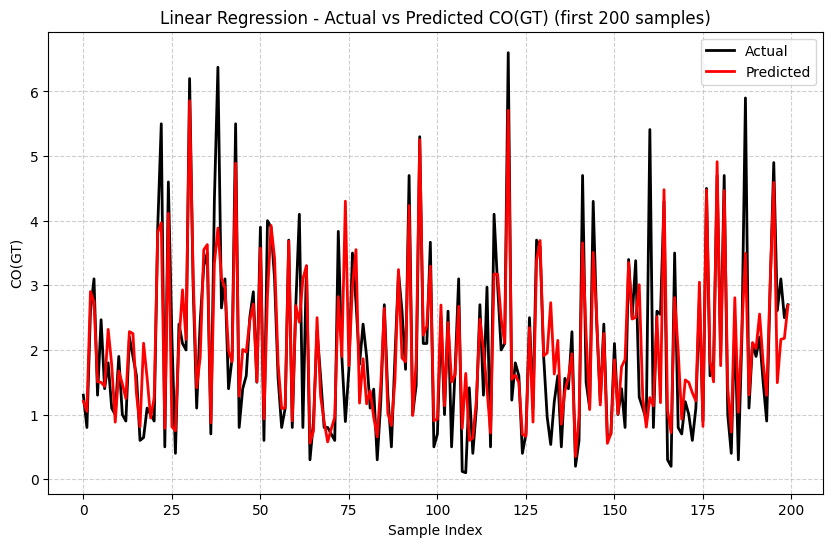

In [6]:
# Train Linear Regression for 5 epochs and record results
from sklearn.linear_model import LinearRegression

# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_train_lr = lin_reg.predict(X_train_scaled)
y_pred_test_lr = lin_reg.predict(X_test_scaled)

# Compute performance metrics
mse_train_lr = mean_squared_error(y_train, y_pred_train_lr)
rmse_train_lr = math.sqrt(mse_train_lr)
r2_train_lr = r2_score(y_train, y_pred_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)
rmse_test_lr = math.sqrt(mse_test_lr)
r2_test_lr = r2_score(y_test, y_pred_test_lr)

# Tabulated output for train and test performance
linear_results = pd.DataFrame({
    'Model': ['Linear Regression'],
    'Train_MSE': [mse_train_lr],
    'Train_RMSE': [rmse_train_lr],
    'Train_R2': [r2_train_lr],
    'Test_MSE': [mse_test_lr],
    'Test_RMSE': [rmse_test_lr],
    'Test_R2': [r2_test_lr]
})

print("\nPerformance comparison for Linear Regression:")
display(linear_results)

# Visualization - Actual vs Predicted (first 200 samples of Test Data)
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:200], label='Actual', color='black', linewidth=2)
plt.plot(y_pred_test_lr[:200], label='Predicted', color='red', linewidth=2)
plt.title("Linear Regression - Actual vs Predicted CO(GT) (first 200 samples)")
plt.xlabel("Sample Index")
plt.ylabel("CO(GT)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Feature Importance for Evaluation**

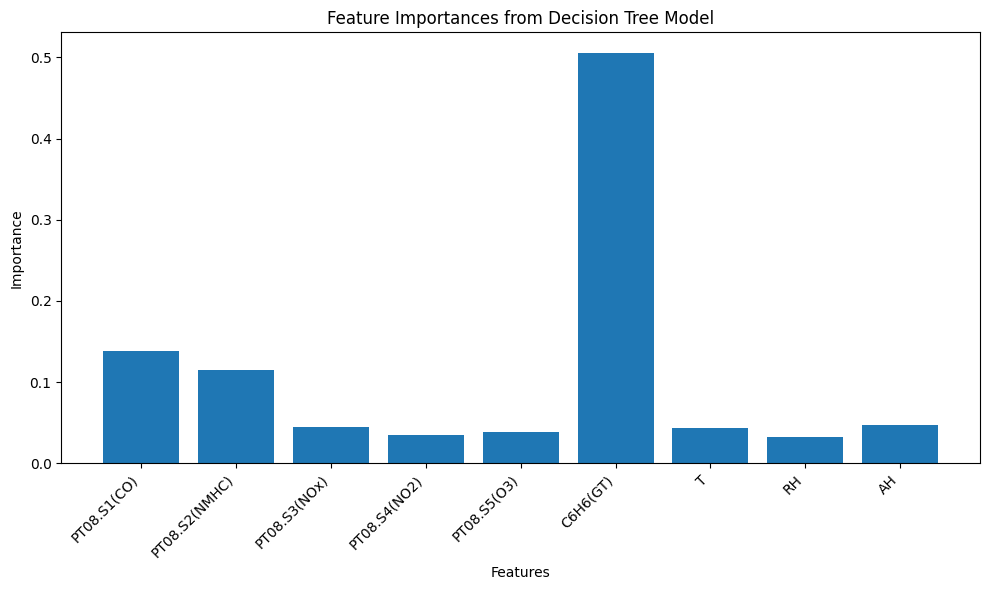

In [9]:
# Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(X.columns, model.feature_importances_)

# Features with the highest bar are the ones that played important role in predicting the desired pollutant.
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Decision Tree Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Comparison between models through results plotting**


Comparison of first 200 samples - Actual vs All Decision Tree depths + Linear Regression:


,Actual,DT_depth3,DT_depth5,DT_depth10,DT_depthNone,LR_Pred,|Diff_depth3|,|Diff_depth5|,|Diff_depth10|,|Diff_depthNone|,|Diff_LR|
0,1.300000,1.708208,1.429522,1.189185,1.600000,1.203904,0.408208,0.129522,0.110815,0.300000,0.096096
1,0.800000,1.252543,1.193114,1.191419,0.900000,1.049054,0.452543,0.393114,0.391419,0.100000,0.249054
2,2.600000,2.812093,2.398903,2.111710,1.800000,2.903489,0.212093,0.201097,0.488290,0.800000,0.303489
3,3.100000,2.812093,3.093530,3.400000,3.500000,2.738118,0.287907,0.006470,0.300000,0.400000,0.361882
4,1.300000,1.252543,1.456106,1.303341,1.591753,1.507835,0.047457,0.156106,0.003341,0.291753,0.207835
5,2.467241,1.252543,1.456106,1.720533,2.000000,1.499595,1.214699,1.011135,0.746708,0.467241,0.967646
6,1.400000,1.252543,1.117846,1.125850,0.900000,1.437132,0.147457,0.282154,0.274150,0.500000,0.037132
7,1.800000,2.247324,2.451607,2.508873,3.100000,2.318625,0.447324,0.651607,0.708873,1.300000,0.518625
8,1.100000,1.708208,1.779234,1.408340,1.228866,1.772154,0.608208,0.679234,0.308340,0.128866,0.672154
9,1.000000,1.252543,1.193114,1.191419,2.521875,0.882537,0.252543,0.193114,0.191419,1.521875,0.117463



Average Absolute Difference per Model:


,Model,Mean Absolute Difference
0,|Diff_depth3|,0.509543
1,|Diff_depth5|,0.493128
2,|Diff_depth10|,0.500388
3,|Diff_depthNone|,0.535651
4,|Diff_LR|,0.453852


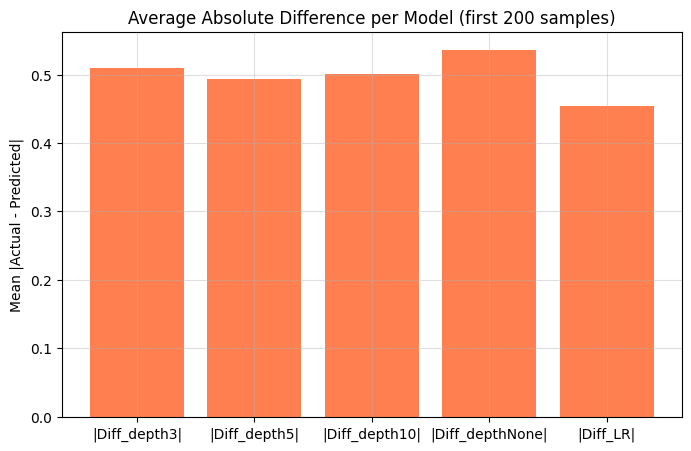

In [8]:
# Comparison between the two models
comparison_all = pd.DataFrame({     # Create DataFrame with actual and predictions
    'Actual': yte[:200],
    'DT_depth3': predictions['3']['test'][:200],
    'DT_depth5': predictions['5']['test'][:200],
    'DT_depth10': predictions['10']['test'][:200],
    'DT_depthNone': predictions['None']['test'][:200],
    'LR_Pred': y_pred_test_lr[:200]
})

# Compute absolute differences from actual
comparison_all['|Diff_depth3|'] = np.abs(comparison_all['Actual'] - comparison_all['DT_depth3'])
comparison_all['|Diff_depth5|'] = np.abs(comparison_all['Actual'] - comparison_all['DT_depth5'])
comparison_all['|Diff_depth10|'] = np.abs(comparison_all['Actual'] - comparison_all['DT_depth10'])
comparison_all['|Diff_depthNone|'] = np.abs(comparison_all['Actual'] - comparison_all['DT_depthNone'])
comparison_all['|Diff_LR|'] = np.abs(comparison_all['Actual'] - comparison_all['LR_Pred'])

# Display first 20 rows for readability
print("\nComparison of first 200 samples - Actual vs All Decision Tree depths + Linear Regression:")
display(comparison_all.head(20))

# Optional: Summary statistics for absolute differences
abs_diff_summary = comparison_all[['|Diff_depth3|','|Diff_depth5|','|Diff_depth10|','|Diff_depthNone|','|Diff_LR|']].mean().reset_index()
abs_diff_summary.columns = ['Model', 'Mean Absolute Difference']
print("\nAverage Absolute Difference per Model:")
display(abs_diff_summary)

# Visualization (optional)
plt.figure(figsize=(8,5))
plt.bar(abs_diff_summary['Model'], abs_diff_summary['Mean Absolute Difference'], color='coral')
plt.title('Average Absolute Difference per Model (first 200 samples)')
plt.ylabel('Mean |Actual - Predicted|')
plt.grid(alpha=0.4)
plt.show()


**Why did I choose CO as the pollutant?**

Among the available pollutants, CO(GT) was selected as the target variable because it exhibits stronger and more consistent correlations with multiple sensor readings (particularly PT08.S1(CO) and C6H6(GT)). Other meteorological parameters (T, RH, AH) were retained for environmental context, while unrelated pollutant columns were removed to focus on CO estimation.

**Discuss Comparison between Decision Tree Regressor and Linear Regression. Which was most suited for such data handling?**
Results show that Linear Regression had the least amount of discrepancy as compared to any other depth of the Regression Tree model proving to be the most suited model for such predictions.

**Which features were most important for predicting your chosen pollutant?**
From the bar charts in feature importance function, it shows that the ones with higher approximity with our desired pollutant (CO) were:
. C6H6
. PT08.S1(CO)
. PT08.S2(NMHC)

**Did deeper trees overfit the training data?**
Yes, as the depth increased, the RMSE for the train data decreased. However, the RMSE for the test data increased substantially.

**Which performed better overall: Decision Tree or Linear Regression? Why?**
As per the last chart provided in the above code, the bar graph shows that the Linear Regression model showed the least amount of absolute error as compared to the Decision Tree Regressor and was thus the best suitable model for such data.